In [2]:
import os, sys
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import math
import math
import pydicom
import nibabel as nib
import torch
import h5py
import matplotlib.pyplot as plt

sys.path.append('/home/vanveen/ConvDecoder/')
from include.mri_helpers import generate_t2_map

In [3]:
def get_file_list(path):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    files.sort()
    return files

def get_id_list(path):
    dirs = [f for f in listdir(path) if isdir(join(path, f))]
    dirs.sort()
    ids = [s.split('_')[1] for s in dirs]
    return ids

- mask is a (512, 512, 160) int array w values [0..6]
- doesn't seem to be lining up w the actual tissue, even if i flip it ud, lr, or ud+lr
- NOTE
    - each dcm alternates b/w t1, t2
        - that's why te alternates b/w [.006, .034]
        - dimn then makes sense, we have 320/2 = 160 slices of 512x512 each
    - `t2_map_wrapped = T2(t2_map_wrapped)` step is irrelevant
    - `tissue.add_quantitative_value(t2_map_wrapped)` step is irrelevant - adds the t2_map attribute to input tissue

### TODO

- i've recon'ed 20 axial slices of (512, 160). want to compare this w gt.
    - for qual comparison, do this slice-wise
    - for quant comparison, do this volume-wise
- use akshay's dcm slices for gt, or .h5 volume?
    - either way, need to make sure pixel value ranges agree
- apply mask. see arjun slack
- look up how to compare t2 map values quantitatively

### load dc volume

In [ ]:
file_id_list = ['005', '006', '030', '034']

In [51]:
slice_idx_list = np.arange(246, 266)

path_dd = '/bmrNAS/people/dvv/out_qdess/accel_4x/echo_joint/specific_slices/'
# file_list_dd = get_file_list(path_dd)

for file_id in file_id_list:
    
    vol_shape = (len(slice_idx_list), 512, 160)
    e1_dc, e2_dc = np.empty(vol_shape), np.empty(vol_shape)
    
    for idx_s, slice_idx in enumerate(slice_idx_list):
    
        fn_e1 = 'MTR_{}_e1_dc_slice{}.npy'.format(file_id, slice_idx)
        fn_e2 = 'MTR_{}_e2_dc_slice{}.npy'.format(file_id, slice_idx)
        
        e1_dc[idx_s] = np.load(path_dd + fn_e1)
        e2_dc[idx_s] = np.load(path_dd + fn_e2)
        
    sys.exit()

SystemExit: 

In [26]:
e1_dc.shape

(20, 512, 160)

### load gt volume

In [56]:
path_dcm = '/bmrNAS/people/akshay/dl/qdess_recon/segmentations/dicoms/'

NUM_SLICES = 160

# indices to crop volume according to dd recon shape of (20,512,160)
idx_s_min, idx_s_max = slice_idx_list.min(), slice_idx_list.max() + 1

for file_id in file_id_list:
    
    path_mtr_dir = '{}MTR_{}/'.format(path_dcm, file_id)
    dcms_mtr = get_file_list(path_mtr_dir)
    if len(dcms_mtr) / 2 != NUM_SLICES:
        print('MTR_{} doesnt contain 160 slices'.format(file_id))
        continue
    
    vol_shape = (512, 512, NUM_SLICES)
    e1_gt_vol, e2_gt_vol = np.empty(vol_shape), np.empty(vol_shape)
        
    for idx_d, d in enumerate(dcms_mtr): # idx_d from 0..320
        if idx_d % 2 != 0:
            continue
        idx_s = idx_d // 2 # idx_s from 0..160
#         print(d, dcms_mtr[idx_d+1])
        
        ds_e1 = pydicom.dcmread(path_mtr_dir + d)
        ds_e2 = pydicom.dcmread(path_mtr_dir + dcms_mtr[idx_d+1])
        
        if ds_e1.FlipAngle != ds_e2.FlipAngle:
            raise ValueError('flip angles for echo1, echo2 disagree')
            
        e1_gt_vol[:,:,idx_s] = ds_e1.pixel_array
        e2_gt_vol[:,:,idx_s] = ds_e2.pixel_array
        
    
    e1_gt = e1_gt_vol[idx_s_min:idx_s_max]
    e2_gt = e2_gt_vol[idx_s_min:idx_s_max]
    
    sys.exit()

SystemExit: 

In [57]:
e1_gt.shape

(20, 512, 160)

<ipython-input-132-a195575acab1>:52: RuntimeWarning: divide by zero encountered in true_divide
  ratio = mask * echo2 / echo1
<ipython-input-132-a195575acab1>:52: RuntimeWarning: invalid value encountered in true_divide
  ratio = mask * echo2 / echo1
<ipython-input-132-a195575acab1>:56: RuntimeWarning: overflow encountered in true_divide
  t2map = (-2000 * (TR - TE) / (np.log(abs(ratio) / k) + c1))
<ipython-input-132-a195575acab1>:56: RuntimeWarning: divide by zero encountered in log
  t2map = (-2000 * (TR - TE) / (np.log(abs(ratio) / k) + c1))


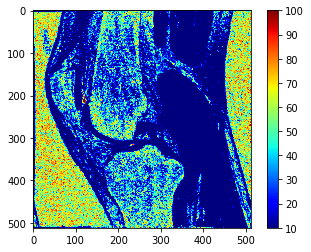

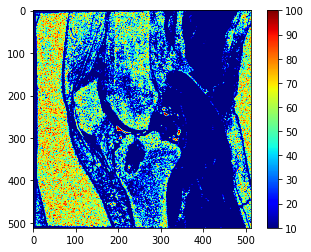

In [156]:
path_dcm = '/bmrNAS/people/akshay/dl/qdess_recon/segmentations/dicoms/'
file_id_list = get_id_list(path_dcm)

NUM_SLICES = 160

file_id_list = ['005', '030']

for file_id in file_id_list:

    path_mtr_dir = '{}MTR_{}/'.format(path_dcm, file_id)
    dcms_mtr = get_file_list(path_mtr_dir)
    if len(dcms_mtr) / 2 != NUM_SLICES:
        print('MTR_{} doesnt contain 160 slices'.format(file_id))
        continue
        
    dcms_mtr = ['I167.dcm', 'I168.dcm']
    for idx_d, d in enumerate(dcms_mtr):
        if idx_d % 2 != 0:
            continue
#         print(d, dcms_mtr[idx_d+1])
        
        ds_e1 = pydicom.dcmread(path_mtr_dir + d)
        ds_e2 = pydicom.dcmread(path_mtr_dir + dcms_mtr[idx_d+1])
        
        if ds_e1.FlipAngle != ds_e2.FlipAngle:
            raise ValueError('flip angles for echo1, echo2 disagree')
            
        e1 = ds_e1.pixel_array
        e2 = ds_e2.pixel_array
        
        t2_map, stats = generate_t2_map(e1, e2, hdr=ds)
        
        plt.imshow(t2_map, cmap='jet')
        plt.colorbar()
        plt.show()
        
#         sys.exit()

In [136]:
path_dcm = '/bmrNAS/people/akshay/dl/qdess_recon/segmentations/dicoms/'

file_id = '030'
idx_slice_list = [50, 80, 95, 110] # slices to plot

mask = nib.load(path_segs + 'MTR_{}.nii.gz'.format(file_id)).get_fdata().astype('int')
# mask = np.flip(mask,2)

file_id_list = get_id_list(path_dcm)

for file_id in file_id_list:

    path_mtr_dir = '{}MTR_{}/'.format(path_dcm, file_id)
    dcms_mtr = get_file_list(path_mtr_dir)

    for idx_d, d in enumerate(dcms_mtr):
        # goes from 0..319 for I001.dcm .. I320.dcm
        # idx_d=0 is I001.dcm is an echo1
        # idx_d=1 is I002.dcm is an echo2
        # ...
        # idx_d=168 is I167.dcm is an echo1

        ds = pydicom.dcmread(path_mtr_dir + d)
        
        tr = float(ds.RepetitionTime) * 1e-3
        te = float(ds.EchoTime) * 1e-3
        alpha = math.radians(float(ds.FlipAngle))

        if idx_d == 0:
            print(idx_d, tr, te, alpha)
                
#         if idx_d % 2 == 0: # do only for echo1's
#             idx_slice = idx_d // 2
#             if idx_slice in idx_slice_list:
                                
#                 mask_slice = mask[:,:,idx_slice].astype('int')
#                 mask_slice = np.rot90(mask_slice, k=3)
# #                 mask_slice = np.flipud(mask_slice)
#                 mask_slice = np.fliplr(mask_slice)

#                 plt.imshow(ds.pixel_array,cmap='gray')
#                 plt.imshow(mask_slice, cmap='jet', clim=(0,6), alpha=0.4)
#                 plt.colorbar()
#                 plt.axis('off')
#                 plt.show()
        
#     sys.exit()

0 0.02036 0.006428 0.3490658503988659
0 0.02036 0.006428 0.3490658503988659
0 0.018352 0.005876 0.3490658503988659
0 0.018352 0.005876 0.3490658503988659
0 0.02036 0.006428 0.3490658503988659
0 0.018352 0.005876 0.3490658503988659
0 0.018352 0.005876 0.3490658503988659
0 0.018352 0.005876 0.3490658503988659
0 0.02036 0.006428 0.3490658503988659
0 0.018352 0.005876 0.3490658503988659
0 0.02036 0.006428 0.3490658503988659
0 0.02036 0.006428 0.3490658503988659


KeyboardInterrupt: 

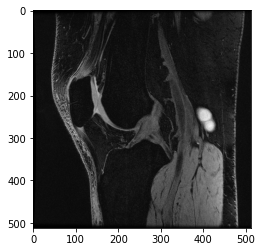

In [131]:
ds = pydicom.dcmread(path_mtr_dir + 'I167.dcm')
arr = ds.pixel_array

plt.imshow(arr,cmap='gray')

In [ ]:
path_m = '/bmrNAS/people/arjun/data/qdess_knee_2020/image_files/'



In [99]:
y = np.bincount(mask.flatten())
ii = np.nonzero(y)[0]

np.vstack((ii,y[ii])).T

array([[       0, 41561328],
       [       1,    49989],
       [       2,   198915],
       [       3,    34919],
       [       4,    39557],
       [       5,    32330],
       [       6,    26002]])